# Introduction


After creating my own RAG package to quickly build a RAG workflow, I discovered that there are techniques other than using classical rerankers to improve the precision of retrieved documents from a vector store.

The technique we’re going to explore today is the **contextualized late interaction** method used on top of BERT by the ranking model **ColBERT**. ColBERT introduced a novel late-interaction paradigm to estimate the relevance between a query and a document — which is essential for **IR** (Information Retrieval) tasks.


# The problem with Rerankers  

A reranker is simply a **cross-encoder**. It takes the query and the document content, processes them together, and produces an embedding for the entire sequence. This results in a rich contextual embedding that deeply understands the relationship between the query and the document.

However, rerankers require **re-encoding the query and all top_k retrieved documents every time**, which quickly becomes computationally expensive. They are very effective but **do not scale** when the number of documents or chunks becomes large. Rerankers are very efficient and allows us to obtain better results but they are not scalable and becomes quickly unusable when the number of chunks/documents becomes big .

# What ColBERT and how it's works ?

ColBERT is a late-interaction model that avoids this scalability issue. It remains efficient while using **a single BERT model**, instead of having separate BERT models for queries and documents.

Suppose we have a document **D** and a query **q**. Both are sequences of tokens. ColBERT uses a: **query encoder : $ f_{Q}$**  and a **document encoder : $f_{D}$** .

<u>  Query Encoding :</u>  

The query is first of all tokenized into its BERT-based WordPiece : $q_{1}q_{2}q_{3}....q_{n}$ and then we add at the beginning the token **[Q]** (just after the **[CLS]** token) to explain to the model that this is the query .  

If the query has fewer than a pre-defined number of tokens $N_{q}$ , we pad it with BERT’s special **[mask]** tokens up to length $N_{q}$ otherwise we truncate it . Then this sequence is passed to a BERT's transformer that will output a contextualized representation of each token , it means that it will output one embedding per token and this embedding takes as a context the other words (tokens) of the sequence .  

Then the ColBERT encoder will pass every embedding through a linear layer with no weights to control the dimension of ColBERT’s embeddings. Typically BERT model output an embedding with a size of 768 and with ColBERT we reduce it to something like 128 .  

And then we normalize all the output embeddings what makes the result of the dot-product of any two embeddings becomes equivalent to their cosine similarity, falling in the [−1, 1] range.

<u>  Document Encoding :</u>

The steps are the same , the two differences are that we don't use a  **[Q]**  token but a **[D]** token and then we don't pad the sequence if it's len gth is smaller than a reference length . The reason is that we don't want to do "document augmentation" .  

We also add a final stap that consists to clean the embeddings by removing all the embeddings associated to punctuation symbols, determined via a pre-defined list.
This filtering is meant to reduce the number of embeddings per document.  

Here is a quick recap of the steps:

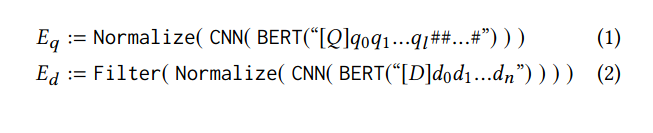  

# Late interaction 

Now that we have the representations of the query and the document we can compute the relevance score between them .  

We take every token of the query and then we calculate the cosine similarity (*which is equal to the dot-products because we normalize the embeddings hehehe*) between the token's embeddings and **every** document token's embedding . Here is an example to make it clear for you:  

Let's imagine we have a query $q$ that is composed of $N$ tokens:  
$$
q = q_{1}q_{2}q_{3}....q_{N}
$$  

And then a document $D$ that is composed of $M$ tokens.  
$$
D = d_{1}d_{2}d_{3}....q_{M}
$$ 

We apply all the steps explained before to obtain embeddings for each tokens of the query and the document.  

The we take let's say $embedding(q_{1})$ and then we compute the dot-product distance between it and all the embeddings of the documents and we put the result in a row. (the dot porduct is represented by **.** )

$$
Distance({q_{1}}) = [embedding(q_{1}).embedding(d_{1})......embedding(q_{1}).embedding(d_{M})]
$$  

After we compute this for all the tokens of the query until we obtain the following matrix:  



$$
\text{Distance}(\text{query}) =
\begin{pmatrix}
\text{embedding}(q_{1}) \cdot \text{embedding}(d_{1}) & \cdots & \text{embedding}(q_{1}) \cdot \text{embedding}(d_{M}) \\
\text{embedding}(q_{2}) \cdot \text{embedding}(d_{1}) & \cdots & \text{embedding}(q_{2}) \cdot \text{embedding}(d_{M}) \\
\vdots & \ddots & \vdots \\
\text{embedding}(q_{N}) \cdot \text{embedding}(d_{1}) & \cdots & \text{embedding}(q_{N}) \cdot \text{embedding}(d_{M})
\end{pmatrix}
$$


And the last step is to take the maximum score of each row and add them all to obtain the **the relevance score of D to q** , this is in reality the sum of similiarity computations.  

For the mathematics lovers here is the math version of what I tried to explain above:  
$$
S_{q,d} := \sum_{i \in[|E_q|]} \max_{j \in[|E_d|]} \mathbf{E}_{q_i} \cdot \mathbf{E}_{d_j}
$$
 Where $E_q$ is the bag of embeddings of the query and $E_d$ the bag of embeddings of the document


# How to use ColBERT ?  

ColBERT can be used in two ways:  

1) **As a Reranker**: To reorder documents that were already retrieved by another initial retrieval model.

2) **As a Full End-to-End Retriever**: This is particularly useful when dealing with a huge number of documents (e.g., 10 million) and you only want to retrieve a small set of k documents.

The retrieval process for the end-to-end retriever has two main steps:

1) **Fast Filtering (Candidate Generation)**: For each token of the query, ColBERT finds the top-k′ most similar document embeddings across the entire document collection using an index (like FAISS). Mapping these embeddings back to their original documents gives a set of candidate documents. The number of unique documents in this set is K. K is usually much smaller than the total number of documents and represents those most likely to be relevant.

2) **Precise Reranking**: ColBERT then reranks only these K candidate documents using the precise MaxSim scoring function to find the most relevant ones. ColBERT first does a fast filter to get $K$ candidate documents and then does a precise reranking on them. This makes it efficient even with very large collections.


# Benchmark :

Here is some benchmarks from the official paper that compares ColBERT model to other re-rerankers and retrieves 

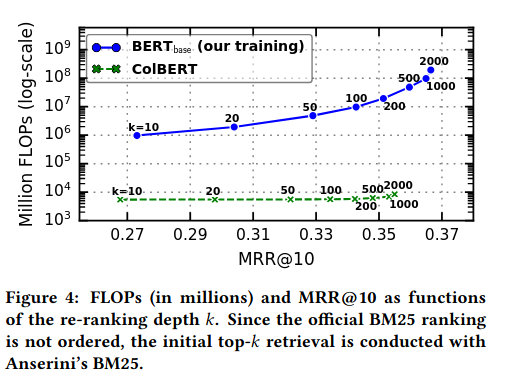 



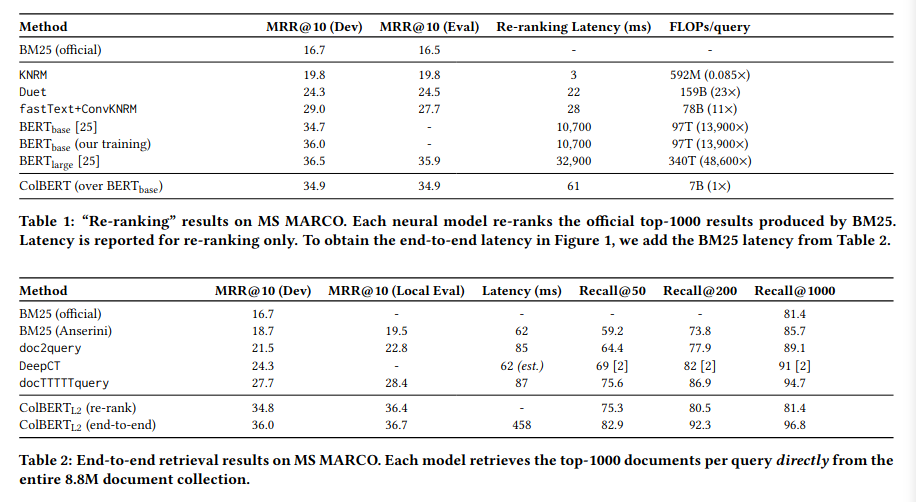

# Implementation :

Now that we know how ColBERT works let's see how ragatouille's framework implements it !

In [ ]:
from ragatouille import RAGPretrainedModel
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
import time
from langchain_classic.document_loaders import DirectoryLoader
from langchain_core.runnables import RunnableLambda,RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser


We  first have to create an index for our documents that will allow us to stock our embeddings and to compute vector search on them 

In [ ]:
def get_index(colbertModel : RAGPretrainedModel , index_path: str):
    """
    Get the index of an existing model
    Args:
        colbertModel (RAGPretrainedModel): the colbert model
        index_path (str): the path of the existing index

    Returns:
        RAGPretrainedModel: The current instance of RAGPretrainedModel, with the model and index initialised.
    """
    try:
        return colbertModel.from_index(index_path=index_path,n_gpu=-1)
    except Exception as e:
        print("Exception raised while trying to get the index : ",e)

Let's define a function to  load and split our document . The point is that we want to not use a world level tokenizer because it is not that much efficient for documents with a lot of words. So for that we will use a tokenizer that first will tokenize our text and the split it by using a token as a count length 

In [ ]:
def load_and_split(path: str):
    """
    Load and split docs into chunks
    
    **path**
    The path where the documents are.
    """    

    loader = DirectoryLoader(
        path=path,
        glob="**/*.pdf",
        use_multithreading=True,
        recursive=True,
        show_progress=False,
    )

    docs = loader.load()
    if not docs:
        raise ValueError("The loader failed to load your documents")

    else:
        print("Documents loaded successfully")
        
        
    tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-small")

    # Use the tokenizer from hugging face to chunk docs
    textsplitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=tokenizer,
        separators=["\n\n", "\n", " ", "", "\n\n"],
        chunk_size=512,
        chunk_overlap=int(512 / 10),
        add_start_index=True,
        strip_whitespace=True,
    )

    if textsplitter is None:
        raise ValueError("Failed to create the text splitter")

    # Chunks the document and times it
    print("Chunking started ..... ")
    start = time.time()
    chunks_docs = textsplitter.split_documents(docs)
    end = time.time()
    print(f"Chunking took  {end - start:.4f} seconds ")


    chunks = [d.page_content for d in chunks_docs]
    if chunks is None:
        raise ValueError("Documents have not been chunked ")

    return chunks

Then we need to create an index from documents , there is one command but you know me I wrapp everything lol.

In [ ]:
def build_index_from_docs(colbertModel : RAGPretrainedModel , 
                         index_name:str,
                         docs: list):

   index_path = colbertModel.index(
        index_name = index_name,
        collection = docs,
        split_documents=False,
        document_splitter_fn=load_and_split,
        
    )
   return index_path

And here we are , we have can use our index as a langchain retriever ! 
So the last part I will create a simple function to create a chain that will allow us to link everything and give the context to an llm that will output the answer of a specific query !

In [ ]:
def get_answer_gemini(
    model: str,
    query:str,
    docs: list[Document],
):
    """
    Generate an answer with gemini llm by giving as context a list of documents
    Args:
        model (str): the gemini model
        query (str): the query
        doc(list[Document]): list of document retrieved

    Returns:
        str: the answer of the query by using the documents as a context
    """
    
    template = """Use the following context to answer the question at the end. 
           You must be respectful and helpful, and answer in the language of the question.
           If you don't know the answer, say that you don't know.

           Context: {context}

           Question: {question}
           """
           
    template_format= ChatPromptTemplate.from_template(template)
    prompt_run = RunnableLambda( lambda args : template_format.format_messages(context=args["context"], question = args["question"]))
    query_runnable = RunnablePassthrough()
    context_runnable = RunnableLambda( lambda _ : "\n\n".join(doc.page_content for doc in docs))
    llm = ChatGoogleGenerativeAI(
    model=model,
    temperature=0.6,
        )

    
    chain = (
        {"context" : context_runnable ,
         "question": query_runnable
         } 
        | prompt_run
        |llm
        |StrOutputParser()
    )
    
    return chain.invoke(query)
    

In [ ]:
colbertModel = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0",verbose=0)

In [ ]:
def query(query:str,
          docs_path: str |None = None,
          index_path: str | None = None):
    """Query your documents by only using this function , it wrapps all the functions above to create a smooth workflow

    Args:
        query (str): The query
        docs_path (str | None, optional): The documents path. Defaults to None. If you already have an index you are not supposed to give the path of your docs 
        index_path (str | None, optional): The index path. Defaults to None. If set to none it creates one

    Returns:
        _type_: _description_
    """
    #Load you .env
    load_dotenv()
    
    # Let's import our colbert model first
    colbertModel = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0",verbose=0)
    
    #If there is an index_path we use this index as a langchain retriever
    if index_path is not None:
        retriever = colbertModel.from_index(index_path,verbose=0).as_langchain_retriever(k=6)
    
    
     # If there is no index created for the docs we create one
    else:
        #We load split our docs
        docs = load_and_split(docs_path)

        # We build and index from these docs
        index_path = build_index_from_docs(colbertModel,"victorHugoIndex",docs)

        #Then we use our model as a langchain retriever
        retriever = colbertModel.from_index(index_path,verbose=0).as_langchain_retriever(k=6)
    
    #Retrieve the relevant docs for the user's query
    retrieved_docs = retriever.invoke(query)

    answer = get_answer_gemini("gemini-2.5-flash",query= query, docs=retrieved_docs)
    
    return answer

In [ ]:
query_text = """ 
La figure de la fille du condamné, Marie, n'apparaît que très brièvement à la fin de l'histoire.

En vous basant sur le texte, décrivez l'évolution émotionnelle du condamné face à sa fille Marie lors de leur dernière rencontre, et expliquez en quoi la confusion de la fillette sur l'identité de son père (le percevant comme un étranger) constitue le "coup de grâce" psychologique, éclipsant même la peur de la mort.

"""

answer = query(query_text,index_path="/home/pepito/Documents/Python/ML/GenAI/ColBert/.ragatouille/colbert/indexes/victorHugoIndex")

In [ ]:
print(answer)